In [68]:
import json
from networkx.readwrite import json_graph
import random
def read_graph_from_json(json_file):
    with open(json_file) as f:
        data = json.load(f)
    return json_graph.adjacency_graph(data) 

In [69]:
# Read Oklahoma county graph from the json file "OK_county.json"
# we want to apply the political districting algorithm on the dynamic airspace configuration problem
# so we need to assign a workload to each county/block
import networkx as nx
filepath = 'districting-data/'
filename = 'OK_county.json'

H= read_graph_from_json(filepath+filename)

print(H)

for node in H.nodes:
    
    county_name = H.nodes[node]['NAME20']
    # assign a random workload for each block from 1 to 10
    H.nodes[node]['workload'] = random.randint(1,10)
    H.nodes[node]['C_X'] = H.nodes[node]['INTPTLON20']  # longitude of block's center
    H.nodes[node]['C_Y'] = H.nodes[node]['INTPTLAT20']  # latitude of block's center
    print("Node",node,"represents",county_name,"County, which had a workload of",H.nodes[node]['workload'])

Graph with 77 nodes and 195 edges
Node 0 represents Washita County, which had a workload of 2
Node 1 represents Jackson County, which had a workload of 8
Node 2 represents Major County, which had a workload of 9
Node 3 represents Delaware County, which had a workload of 9
Node 4 represents Custer County, which had a workload of 9
Node 5 represents Ellis County, which had a workload of 2
Node 6 represents Oklahoma County, which had a workload of 5
Node 7 represents Johnston County, which had a workload of 8
Node 8 represents Comanche County, which had a workload of 8
Node 9 represents Pushmataha County, which had a workload of 4
Node 10 represents Cleveland County, which had a workload of 6
Node 11 represents Wagoner County, which had a workload of 10
Node 12 represents Beckham County, which had a workload of 9
Node 13 represents Garvin County, which had a workload of 6
Node 14 represents Craig County, which had a workload of 8
Node 15 represents Cherokee County, which had a workload of

In [70]:

def get_key(node):
    # Priority is longitude (west to east)
    # Latitude is secondary (north to south) 
    return (H.nodes[node]['C_X'], -1 * H.nodes[node]['C_Y'])  

nodes = list(H.nodes())
nodes.sort(key=get_key)

G = nx.DiGraph()
new_id = 0
node_map = {}

for n in nodes:
    G.add_node(new_id,  
               NAME20=H.nodes[n]['NAME20'],
               workload=H.nodes[n]['workload'],
               C_X=H.nodes[n]['C_X'], 
               C_Y=H.nodes[n]['C_Y'],
               GEOID20 = H.nodes[n]['GEOID20']) 
               
    node_map[new_id] = n
    print("Node",new_id,"represents",H.nodes[n]['NAME20'],"block, which had a workload of",H.nodes[n]['workload'])
    new_id += 1

print("Node mapping:")   
print(node_map)  

print("\nNodes in order:")
print(list(G.nodes()))

Node 0 represents Adair block, which had a workload of 2
Node 1 represents Le Flore block, which had a workload of 5
Node 2 represents Sequoyah block, which had a workload of 2
Node 3 represents McCurtain block, which had a workload of 2
Node 4 represents Ottawa block, which had a workload of 7
Node 5 represents Delaware block, which had a workload of 9
Node 6 represents Cherokee block, which had a workload of 8
Node 7 represents Haskell block, which had a workload of 1
Node 8 represents Craig block, which had a workload of 8
Node 9 represents Mayes block, which had a workload of 1
Node 10 represents Latimer block, which had a workload of 10
Node 11 represents Muskogee block, which had a workload of 10
Node 12 represents Pushmataha block, which had a workload of 4
Node 13 represents Wagoner block, which had a workload of 10
Node 14 represents Choctaw block, which had a workload of 7
Node 15 represents Rogers block, which had a workload of 2
Node 16 represents Nowata block, which had a 

In [71]:
from geopy.distance import geodesic

# create distance dictionary
dist = { (i,j) : 0 for i in G.nodes for j in G.nodes }
for i in G.nodes:
    for j in G.nodes:
        loc_i = ( G.nodes[i]['C_Y'], G.nodes[i]['C_X'] )
        loc_j = ( G.nodes[j]['C_Y'], G.nodes[j]['C_X'] )
        dist[i,j] = geodesic(loc_i,loc_j).miles

In [72]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

# create x[i,j] variable which equals one when block i 
#    is assigned to (the sector with its last) block j
x = m.addVars( G.nodes, G.nodes, vtype=GRB.BINARY )

In [73]:
# objective is to minimize the variance of workload for each sector:
obj = gp.QuadExpr()
obj = (gp.quicksum(G.nodes[i]['workload']*x[i,j] for i in G.nodes) - (gp.quicksum(G.nodes[i]['workload'] for i in G.nodes)/len(G))* x[j,j])*(gp.quicksum(G.nodes[i]['workload']*x[i,j] for i in G.nodes) - (gp.quicksum(G.nodes[i]['workload'] for i in G.nodes)/len(G))*x[j,j])

obj1 = gp.QuadExpr()
obj1 = (G.nodes[i]['workload']*x[i,j]-(gp.quicksum(G.nodes[i]['workload'] for i in G.nodes)/len(G))* x[j,j])*(G.nodes[i]['workload']*x[i,j]-(gp.quicksum(G.nodes[i]['workload'] for i in G.nodes)/len(G))*x[j,j])
# m.setObjective(gp.quicksum(obj for j in G.nodes), GRB.MINIMIZE)
m.setObjective(gp.quicksum(obj1 for i in G.nodes for j in G.nodes), GRB.MINIMIZE)

In [74]:
k = 5  # number of sectors/ATCOs
# add constraints saying that each block i is assigned to one sector j
m.addConstrs( gp.quicksum( x[i,j] for j in G.nodes) == 1 for i in G.nodes)
# m.addConstrs( x.sum(i, i+1, '*') == 1 for i in G.nodes)

# add constraint saying there should be k sectors
m.addConstr( gp.quicksum( x[j,j] for j in G.nodes ) == k )

# add coupling constraints saying that if i is assigned to j, then j is a center.
m.addConstrs(x[i,j] <= x[j,j] for i in G.nodes for j in G.nodes)

{(0, 0): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 2): <gurobi.Constr *Awaiting Model Update*>,
 (0, 3): <gurobi.Constr *Awaiting Model Update*>,
 (0, 4): <gurobi.Constr *Awaiting Model Update*>,
 (0, 5): <gurobi.Constr *Awaiting Model Update*>,
 (0, 6): <gurobi.Constr *Awaiting Model Update*>,
 (0, 7): <gurobi.Constr *Awaiting Model Update*>,
 (0, 8): <gurobi.Constr *Awaiting Model Update*>,
 (0, 9): <gurobi.Constr *Awaiting Model Update*>,
 (0, 10): <gurobi.Constr *Awaiting Model Update*>,
 (0, 11): <gurobi.Constr *Awaiting Model Update*>,
 (0, 12): <gurobi.Constr *Awaiting Model Update*>,
 (0, 13): <gurobi.Constr *Awaiting Model Update*>,
 (0, 14): <gurobi.Constr *Awaiting Model Update*>,
 (0, 15): <gurobi.Constr *Awaiting Model Update*>,
 (0, 16): <gurobi.Constr *Awaiting Model Update*>,
 (0, 17): <gurobi.Constr *Awaiting Model Update*>,
 (0, 18): <gurobi.Constr *Awaiting Model Update*>,
 (0, 19): <gurobi.Constr *Awaiting Model 

In [75]:
# # add contiguity constraints
# import networkx as nx
# DG = nx.DiGraph(G)

# # add flow variables
# #    f[i,j,v] = flow across arc (i,j) that is sent from souce/root v
# f = m.addVars( DG.edges, G.nodes ) 

# # add constraints saying that if node i is assigned to node j, 
# #   then node i must consume one unit of node j's flow
# m.addConstrs( gp.quicksum( f[u,i,j] - f[i,u,j] for u in G.neighbors(i) ) == x[i,j] for i in G.nodes for j in G.nodes if i != j )

# # add constraints saying that node i can receive flow of type j 
# #   only if node i is assigned to node j
# M = G.number_of_nodes() - 1
# m.addConstrs( gp.quicksum( f[u,i,j] for u in G.neighbors(i) ) <= M * x[i,j] for i in G.nodes for j in G.nodes if i != j )

# add constraints saying that node j cannot receive flow of its own type
# m.addConstrs( gp.quicksum( f[u,j,j] for u in G.neighbors(j) ) == 0 for j in G.nodes )

# m.update()

In [76]:
# solve, making sure to set a 0.00% MIP gap tolerance
m.Params.MIPGap = 0.0

m.optimize()

Set parameter MIPGap to value 0
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: AMD Ryzen Threadripper 3990X 64-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads

Optimize a model with 6007 rows, 5929 columns and 17710 nonzeros
Model fingerprint: 0xa35c6e7b
Model has 1 quadratic objective term
Variable types: 0 continuous, 5929 integer (5929 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+05, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 0.0000000
Presolve removed 77 rows and 0 columns
Presolve time: 0.07s
Presolved: 5930 rows, 5929 columns, 17710 nonzeros
Variable types: 0 continuous, 5929 integer (5929 binary)

Explored 0 nodes (0 simplex iterations) in 0.08 seconds (0.05 work units)
Thread count was 32 (of 128 available processors)

Solution coun

In [77]:
# print the objective value
print(m.objVal)

# retrieve the sectors and their workloads
#    but first get the last block in index order for each sector"

lastBlock = [ j for j in G.nodes if x[j,j].x > 0.5 ]

sectors = [ [ i for i in G.nodes if x[i,j].x > 0.5 ] for j in lastBlock ]
sector_blocks = [ [ G.nodes[i]["NAME20"] for i in sectors[j] ] for j in range(k)]
sector_workloads = [ sum(G.nodes[i]["workload"] for i in sectors[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("Sector",j,"has workload",sector_workloads[j],"and contains blocks",sector_blocks[j])
    print("")

0.0
Sector 0 has workload 92 and contains blocks ['Adair', 'Le Flore', 'Sequoyah', 'McCurtain', 'Mayes', 'Nowata', 'Washington', 'Okmulgee', 'Pawnee', 'Marshall', 'Payne', 'Carter', 'Oklahoma', 'Grant', 'Cotton', 'Comanche', 'Tillman', 'Kiowa']

Sector 1 has workload 116 and contains blocks ['Ottawa', 'Delaware', 'Cherokee', 'Craig', 'Wagoner', 'McIntosh', 'Creek', 'Seminole', 'Garvin', 'Grady', 'Kingfisher', 'Caddo', 'Washita', 'Beckham', 'Harmon', 'Cimarron']

Sector 2 has workload 46 and contains blocks ['Haskell', 'Pushmataha', 'Atoka', 'Bryan', 'Pontotoc', 'Lincoln', 'Kay', 'Blaine', 'Jackson', 'Texas']

Sector 3 has workload 139 and contains blocks ['Latimer', 'Muskogee', 'Choctaw', 'Rogers', 'Pittsburg', 'Tulsa', 'Osage', 'Johnston', 'Murray', 'Noble', 'Love', 'Cleveland', 'McClain', 'Jefferson', 'Canadian', 'Alfalfa', 'Woods', 'Custer', 'Greer', 'Ellis', 'Beaver']

Sector 4 has workload 78 and contains blocks ['Hughes', 'Coal', 'Okfuskee', 'Pottawatomie', 'Logan', 'Garfield', '

In [78]:
# Let's draw it on a map
import geopandas as gpd

In [79]:
# Read Oklahoma county shapefile from "OK_county.shp"
filepath = 'districting-data/'
filename = 'OK_county.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filepath + filename )

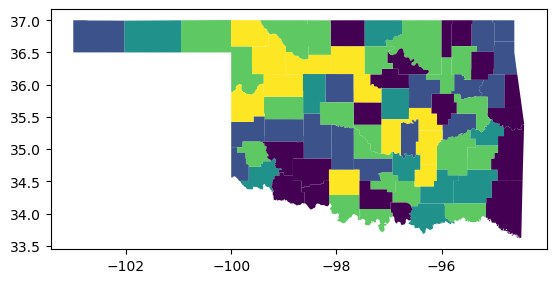

In [80]:
# Which district is each county assigned to?
assignment = [ -1 for i in G.nodes ]

labeling = { i : -1 for i in G.nodes }
for j in range(k):
    sector = sectors[j]
    for i in sector:
        labeling[i] = j

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

# pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same sector # that block i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()